<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Measuring Return](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.01-Measuring-Return.ipynb) | [Contents](toc.ipynb) | [Binomial Model for Pricing Options](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.03-Binomial-Model-for-Pricing-Options.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/07.02-Geometric-Brownian-Motion.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/07.02-Geometric-Brownian-Motion.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Geometric Brownian Motion

This notebook presents methods for modeling a financial time series as geometric Brownian motion. The basic outline is to:

1. Capture a data series.
2. Compute returns (we'll do both linear and log returns).
3. Test statistical properties. We need the returns to be independent and identically distributed (iid).
4. Fit distribution of returns to a normal distribution.
5. Perform simulations.

## Python Imports and Utility Functions

The [`pandas-datareader`](https://pandas-datareader.readthedocs.io/en/latest/#) package provides a utility for accessing on-line data sources of data. Since the interfaces to those data sources are constantly changing, the next cell updates any current installation of the data reader to the latest available version.

In [4]:
%%capture
!pip install pandas_datareader --upgrade

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

In [6]:
# python libraray for accessing internet resources
import requests

def lookup_yahoo(symbol):
    """Return a list of all matches for a symbol on Yahoo Finance."""
    url = f"http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={symbol}&region=1&lang=en"
    return requests.get(url).json()["ResultSet"]["Result"]

def get_symbol(symbol):
    """Return exact match for a symbol."""
    result = [r for r in lookup_yahoo(symbol) if symbol == r['symbol']]
    return result[0] if len(result) > 0 else None

## Statistical Properties of Returns

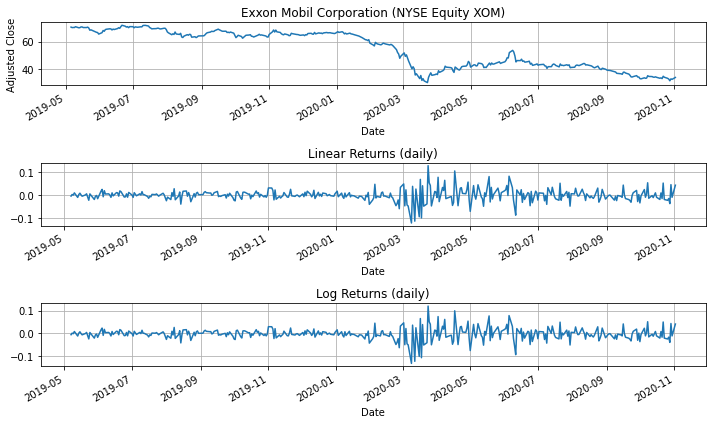

In [9]:
symbol = 'XOM'

# get symbol data
symbol_data = get_symbol(symbol)
assert symbol_data, f"Symbol {symbol} wasn't found."

# end date is today
end = datetime.datetime.today().date()

# start date is three years prior
start = end-datetime.timedelta(1.5*365)

# get stock price data
S = data.DataReader(symbol,"yahoo",start,end)['Adj Close']
rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

# plot data
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
title = f"{symbol_data['name']} ({symbol_data['exchDisp']} {symbol_data['typeDisp']} {symbol_data['symbol']})"
S.plot(title=title)
plt.ylabel('Adjusted Close')
plt.grid()

plt.subplot(3,1,2)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.grid()
plt.tight_layout()

plt.subplot(3,1,3)
rlog.plot()
plt.title('Log Returns (daily)')
plt.grid()
plt.tight_layout()

### Distribution of Returns

A basic assumption in developing developing stochastic price models is that the residuals are indepdendent and identically distributed (i.i.d.) random variates.  Here we show the results of several common statistical tests that would screen out non-i.i.d. random variates.

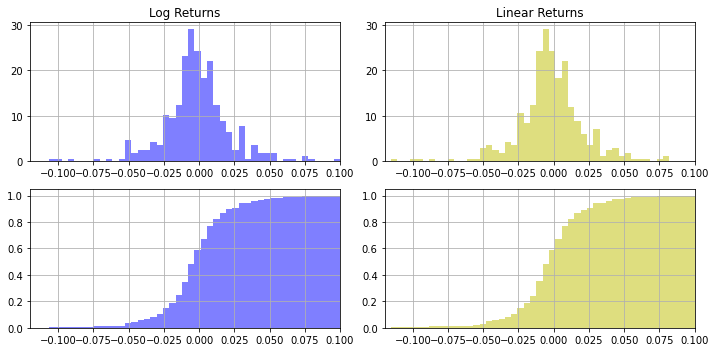

In [13]:
bins = np.linspace(-0.12,0.10,50)
plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
rlog.hist(bins=bins, density=True, color='b', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Log Returns')

plt.subplot(2,2,3)
rlog.hist(bins=bins, density=True, cumulative=True, color='b',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.subplot(2,2,2)
rlin.hist(bins=bins, density=True, color='y', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Linear Returns')

plt.subplot(2,2,4)
rlin.hist(bins=bins, density=True, cumulative=True, color='y',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.tight_layout()

### Distribution of First Half versus Second Half of the Data Set

Text(0.5, 1.0, 'Change in Distribution of Log Returns')

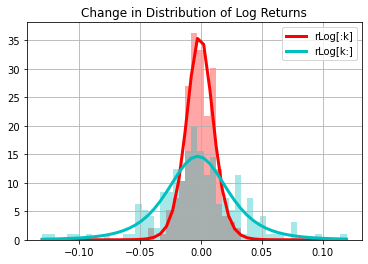

In [20]:
from scipy.stats import t

k = int(len(rlog)/2)
r = np.linspace(rlog.min(),rlog.max())

plt.figure();

param = t.fit(rlog[:k])
rlog[:k].hist(bins=r, density=True, alpha=0.35, color='r')
plt.plot(r,t.pdf(r,df=param[0],loc=param[1],scale=param[2]),'r-',lw=3);

rlog[k:].hist(bins=r, density=True, alpha=0.35, color='c')
param = t.fit(rlog[k:])
plt.plot(r,t.pdf(r, df=param[0], loc=param[1], scale=param[2]), 'c-',lw=3);

plt.legend(['rLog[:k]', 'rLog[k:]'])
plt.title('Change in Distribution of Log Returns')

In [15]:
t.fit(rlog[:k].dropna())

(10.642356864200496, -0.0010115050831410745, 0.010849748093910396)

### Lag Plot of $r^{log}_{t+1}$ versus $r^{log}_t$

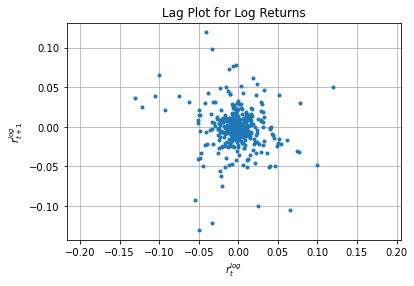

In [16]:
plt.plot(rlog[0:-1], rlog[1:],'.')
plt.axis('equal');
plt.xlabel('$r^{log}_{t}$')
plt.ylabel('$r^{log}_{t+1}$')
plt.grid()
plt.title('Lag Plot for Log Returns');

### Autocorrelation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


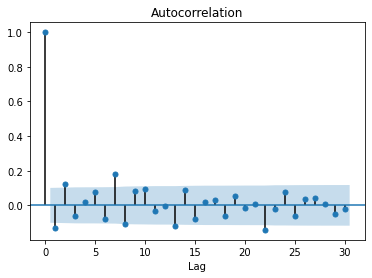

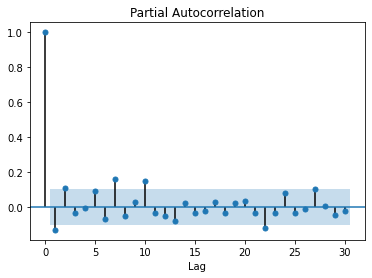

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(rlog, lags=min(30, len(rlog)));
plt.xlabel('Lag');
plot_pacf(rlog, lags=min(30, len(rlog)));
plt.xlabel('Lag');

## Fitting Returns to a Distribution

### Normal Distribution

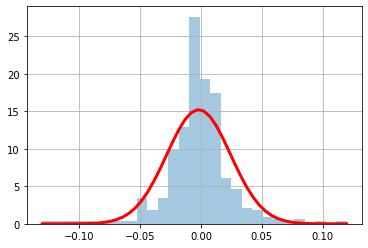

<Figure size 432x288 with 0 Axes>

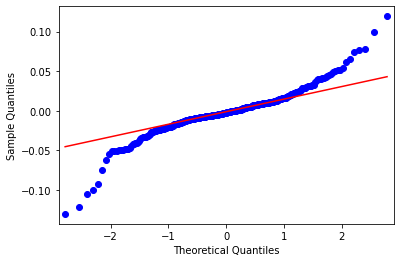

In [19]:
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

r = np.linspace(rlog.min(), rlog.max())

plt.figure()
param = norm.fit(rlog)
rlog.hist(bins=int(1.5*np.sqrt(len(rlog))), density=True,alpha=0.4)
plt.plot(r,norm.pdf(r,loc=param[0],scale=param[1]),'r-',lw=3)

plt.figure()
qqplot(rlog,line='q');

## Geometric Brownian Motion

### Linear Returns 

A discrete-time model for prices modeled as geometric Brownian motion is given by 

$$S_{k+1} = S_k + \mu S_k \Delta t + \sigma S_k \sqrt{\Delta t} Z_k$$

where $Z_k \sim N(0,1)$ and $\Delta t$ corresponds to a sampling period, typically a trading period. There are normally 252 trading days in a calendar year, 63 trading days in a quarter, and 21 trading days in a month.

Defining the linear return as

$$r^{lin}_{k} = \frac{S_k - S_{k-1}}{S_{k-1}} = \mu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

then the statistical model for linear returns becomes

$$r^{lin}_{k} = \mu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

This shows, for the case of Geometric Brownian Motion, $r^{lin}_k$ is a random variable drawn from a the normal distribution 

$$r^{lin}_k \sim N(\mu \Delta t, \sigma\sqrt{\Delta t})$$

### Log Returns

Alternatively, geometric Brownian motion for prices can be modeled using the natural logarithm of price,

$$\ln S_{k+1} = \ln S_k + \nu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

where, as for linear returns, $Z_k \sim N(0,1)$ and $\Delta t$ corresponds to a sampling period. The relationship between linear and log returns is given by 

$$\nu \approx \mu - \frac{\sigma^2}{2}$$

where $\frac{\sigma^2}{2}$ is the 'volatility drag' on linear returns. Defining log return as 

$$r^{log}_k = \ln S_k - \ln S_{k-1} = \nu \Delta t + \sigma \sqrt{\Delta t} Z_k$$

the statistical model for log returns becomes

\begin{align*}
r^{log}_{k} & = \nu \Delta t + \sigma \sqrt{\Delta t} Z_k \\
& \sim N(\nu \Delta t, \sigma\sqrt{\Delta t})
\end{align*}

This shows, for the case of Geometric Brownian Motion, $r^{log}_k$ is a random variable drawn from a the normal distribution. The following cells is a complete self-contained demonstration of downloading a data series, fitting a GBM price model, and performing simulations. The first cell loads a data series, computes linear and log returns, and estimates values for $\mu$, $\nu$, and $\sigma$.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests

def get_symbol(symbol):
    """
    get_symbol(symbol) uses Yahoo to look up a stock trading symbol and 
    return a description.
    """
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

symbol = 'X'

# end date is today
end = datetime.datetime.today().date()
start = end-datetime.timedelta(3*365)

# get stock price data
S = data.DataReader(symbol,"yahoo",start,end)['Adj Close']

rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

print('Linear Returns')
mu,sigma = norm.fit(rlin)
print('   mu = {0:12.8f}  (annualized = {1:.2f}%)'.format(mu,100*252*mu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))
print()
print('Log Returns')
nu,sigma = norm.fit(rlog)
print('   nu = {0:12.8f}  (annualized = {1:.2f}%)'.format(nu,100*252*nu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

Linear Returns
   mu =  -0.00062542  (annualized = -15.76%)
sigma =   0.03744556  (annualized = 59.44%)

Log Returns
   nu =  -0.00133253  (annualized = -33.58%)
sigma =   0.03768694  (annualized = 59.83%)


### Forecasting

The second cell performs $N$ simulations over a time period $T$, and plots the results with the historical data.

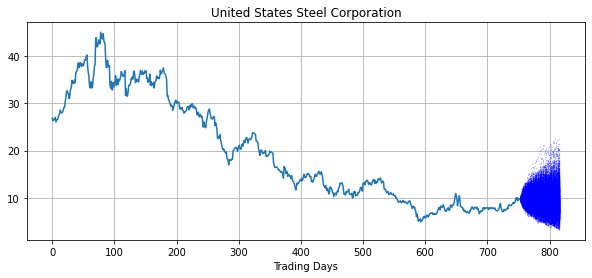

In [22]:
from scipy.stats import norm

N = 1000
T = 63
dt = 1

plt.figure(figsize=(10,4))
plt.plot(S.values)
plt.title(get_symbol(symbol))
plt.xlabel('Trading Days')

Slog = []  # log of final values
for n in range(0,N):
    P = S[-1]       # returns the last price in the sequence
    k = len(S)
    Plog = []
    tlog = []
    for t in range(len(S)+1,len(S)+T+1):
        Z = norm.rvs()
        P += P*(mu*dt + sigma*np.sqrt(dt)*Z)
        Plog.append(P)
        tlog.append(t)
    plt.plot(tlog,Plog,'b.',ms=0.4,alpha=0.5)
    Slog.append(P)

plt.grid()

0.30258689377303005 0.0 8.994592497389538


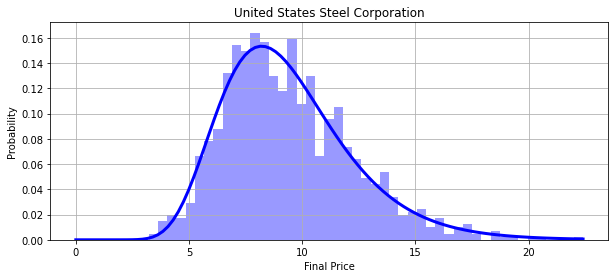

In [24]:
from scipy.stats import lognorm

plt.figure(figsize=(10,4))
nbins = min(100,int(1.5*np.sqrt(N)))
plt.hist(Slog, bins=nbins, density=True, alpha=0.4, color='b');

shape,loc,scale = lognorm.fit(Slog,floc=0)
print(shape,loc,scale)
x=np.linspace(0,max(Slog),100) 
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plt.plot(x,pdf_fitted,'b-',lw=3)
plt.xlabel('Final Price')
plt.ylabel('Probability');
plt.title(get_symbol(symbol))
plt.grid()

### Simulation using Generators

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


ValueError: ignored

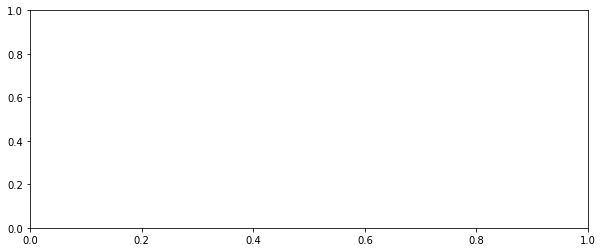

In [33]:
from scipy.stats import norm,lognorm

param = norm.fit(S)
alpha = param[0]
beta = param[1]

N = 10000
T = 252
h = 1

# Initialize P
Pgbm = np.array([S[-1]]*N)

# generator of random variates
Zgenerator = (np.array(norm.rvs(loc=alpha*h,scale=beta*np.sqrt(h),size=N)) for k in range(0,T))

for Z in Zgenerator:
    Pgbm += Pgbm*Z
    
plt.figure(figsize=(10,4))
nbins = min(100,int(1.5*np.sqrt(N)))
plt.hist(Pgbm, bins=nbins, density=1, alpha=0.4, color='b');

shape,loc,scale = lognorm.fit(Pgbm, floc=0)
print(shape, loc, scale)
x=np.linspace(0,max(Pgbm),100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plot(x,pdf_fitted,'b-',lw=3)
xlabel('Final Price')
ylabel('Probability');
title(description)

<!--NAVIGATION-->
< [Measuring Return](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.01-Measuring-Return.ipynb) | [Contents](toc.ipynb) | [Binomial Model for Pricing Options](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.03-Binomial-Model-for-Pricing-Options.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/07.02-Geometric-Brownian-Motion.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/07.02-Geometric-Brownian-Motion.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>